In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
import pandas as pd
import matplotlib.patches as mpatches

In [5]:
input_image = 'banana.JPG'

Step1: Remove Plates and Stuff

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2024-01-25 12:09:57.846631: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


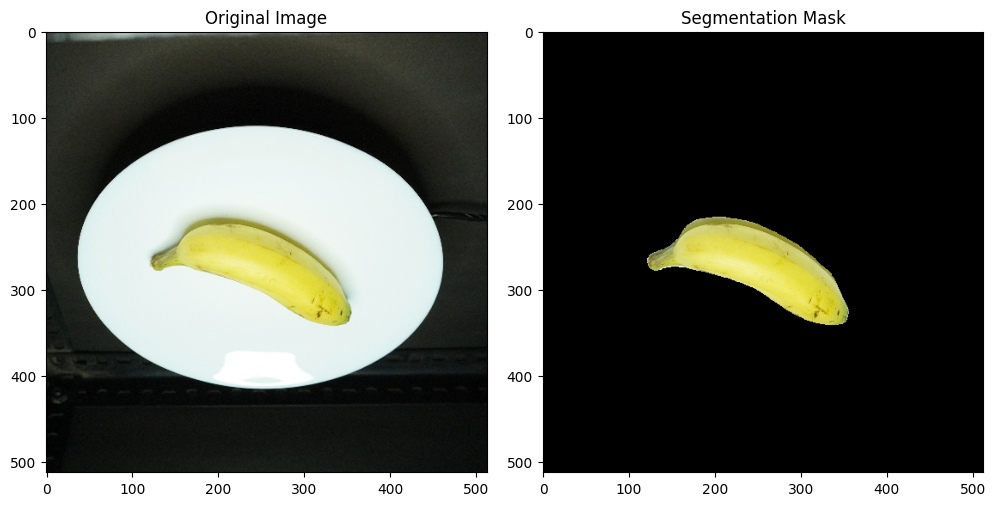

In [6]:


# Extract the tar.gz model
model_filename = 'seefood_segmenter_mobile_food_segmenter_V1_1.tar.gz'
extracted_folder_path = 'extracted_model'

if not os.path.exists(extracted_folder_path):
    with tarfile.open(model_filename, 'r:gz') as tar:
        tar.extractall(path=extracted_folder_path)

# 1. Load the image
# image_path = 'test.jpg'
image_path = input_image
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
image = image / 255.0  # Normalize to [0, 1]

# Check if the image is 3-channel RGB
if image.shape[-1] != 3:
    print("Make sure your image is RGB.")

# Expand dimensions for batch
image_batch = tf.expand_dims(image, 0)

# 2. Load the local model with specified output keys
m = hub.KerasLayer(extracted_folder_path, signature_outputs_as_dict=True)

# 3. Use the model
results = m(image_batch)

segmentation_probs = results['food_group_segmenter:semantic_probabilities'][0]
segmentation_mask = results['food_group_segmenter:semantic_predictions'][0]

# Define the label classes to remove (adjust as needed)
classes_to_remove = [0, 23, 24]  # Example: Remove classes 2, 4, and 6

# Create a mask to remove the specified classes
mask_to_remove = np.isin(segmentation_mask, classes_to_remove)

# Apply the mask to remove the corresponding regions from the original image
image_without_classes = image * (1 - mask_to_remove[..., tf.newaxis])  # Set to black (or any desired background color)

# Save the modified image without specified classes
output_image_path = 'modified_image.jpg'  # Specify the desired output path and filename
tf.keras.preprocessing.image.save_img(output_image_path, image_without_classes.numpy())  # Save the modified image


# 4. Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(image_without_classes.numpy())
plt.title('Segmentation Mask')

# plt.subplot(1, 3, 3)
# # Overlay the segmentation mask on the original image
# class_id = 5
# overlay = np.where(segmentation_mask == class_id, 1, 0)
# plt.imshow(image)
# plt.imshow(overlay, alpha=0.5)
# plt.title(f'Overlay (for class {class_id})')

plt.tight_layout()
plt.show()




Monocular Depth Estimation

In [8]:
from PIL import Image
import numpy as np
import requests
import torch
import sys

from transformers import DPTForDepthEstimation, DPTFeatureExtractor

torch.device('cpu')

model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=False)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

if sys.argv[1] == '':
    image = Image.open('banana.JPG')
else:
    image = Image.open(str(sys.argv[1]))

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
print(output)
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
# depth.show()

depth.save("output.png")

FileNotFoundError: [Errno 2] No such file or directory: '--f=/home/ashikh/.local/share/jupyter/runtime/kernel-v2-2665zGczx49iEcK9.json'

In [ ]:
import numpy as np
import pyntcloud

from pyntcloud import PyntCloud
import cv2
import pandas as pd
from scipy.spatial import Delaunay
from stl import mesh

# Load the segmented depth image as a NumPy array
image_path = "MDE_Masked.jpg"
image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
segmented_depth_image = image

print(segmented_depth_image)

# Extract depth values within the segmented food region
depth_values = segmented_depth_image[segmented_depth_image > 0]


# Assuming pixel coordinates represent (x, y) and depth represents z,
# create a 3D point cloud
height, width = segmented_depth_image.shape
y_coords, x_coords = np.where(segmented_depth_image > 0)
point_cloud = np.column_stack((x_coords, y_coords, depth_values))

# Create a PyntCloud object from the point cloud
cloud = PyntCloud(points=pd.DataFrame(point_cloud, columns=["x", "y", "z"]))

# Compute Delaunay triangulation of the 3D point cloud
triangulation = Delaunay(cloud.points.values[:, :2])  # Consider only (x, y) coordinates

# Create a mesh from the triangulation
mesh_vertices = cloud.points.values
faces = triangulation.simplices

# Calculate the volume of the mesh
mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        mesh.vectors[i][j] = mesh_vertices[f[j], :]

# Calculate the volume of the mesh
volume = mesh.get_mass_properties()[0]

# Print the estimated volume
print(f"Estimated volume of food: {volume} cubic units")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Estimated volume of food: 3126385.8333333335 cubic units


In [ ]:
!pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b5/24/aaccf324ce862bb82277e8814d2aebbb2a2c160d04e95aa2b8c9dc3137a9/matplotlib-3.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached matplotlib-3.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/f1/6b/e4b0f8708f22dd7c321f87eadbb98708975e115ac6582eb46d1f32197ce6/contourpy-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached contourpy-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.9 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/2b/e8/61b8525acf26ec222518bdff127ae502bfa3408981fb5e5493f2b037d7fb/fonttools-4.42.1-cp310-cp310-manylinux_2_17_x86_64.manylinux

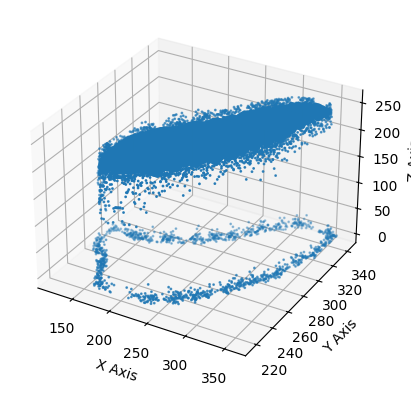

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a point cloud in the variable 'point_cloud'
# It should be a 2D NumPy array with columns for x, y, and z coordinates

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)  # 's' controls point size

# Set axis labels (customize as needed)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()


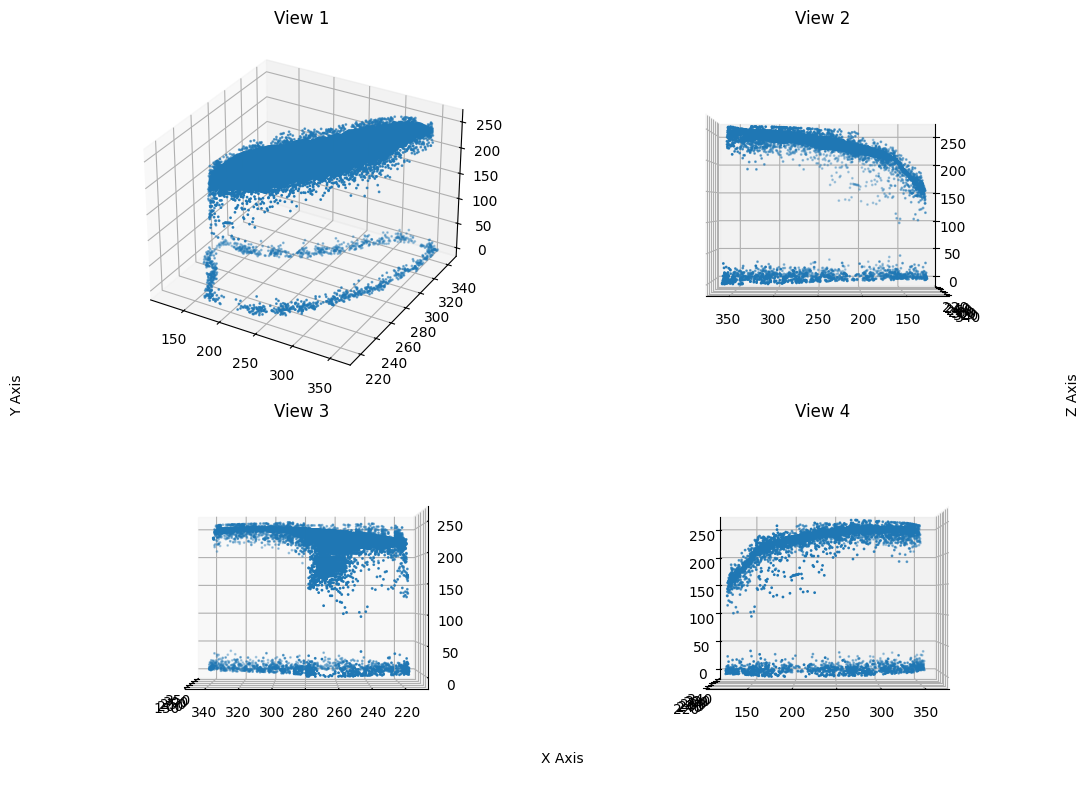

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a point cloud in the variable 'point_cloud'
# It should be a 2D NumPy array with columns for x, y, and z coordinates

# Create a figure with four subplots
fig = plt.figure(figsize=(12, 8))

# Create the first subplot (top-left)
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax1.set_title('View 1')

# Create the second subplot (top-right)
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax2.view_init(elev=0, azim=90)  # Adjust the view angle (elevation and azimuth)
ax2.set_title('View 2')

# Create the third subplot (bottom-left)
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax3.view_init(elev=0, azim=180)  # Adjust the view angle
ax3.set_title('View 3')

# Create the fourth subplot (bottom-right)
ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax4.view_init(elev=0, azim=270)  # Adjust the view angle
ax4.set_title('View 4')

# Set common labels for the entire figure
fig.text(0.5, 0.04, 'X Axis', ha='center')
fig.text(0.04, 0.5, 'Y Axis', va='center', rotation='vertical')
fig.text(0.92, 0.5, 'Z Axis', va='center', rotation='vertical')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from scipy.spatial import ConvexHull

# Calculate the Convex Hull of the point cloud
hull = ConvexHull(point_cloud)

# The volume of the Convex Hull can be used as an estimate of the volume of the point cloud
estimated_volume = hull.volume

print(f"Estimated volume: {estimated_volume}")